In [1]:
%run /home/analysis_user/New_trap_code/Tools/basic_packages.py
sys.path.append('/home/analysis_user/New_trap_code/SensitivityFramework/')
from signal_model_utilities_v3 import *
from shutil import copyfile


plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
x_sep = 13.9#10.39
height_sep=-15.5#-15.7
stroke=-202.11
frequency=3
lambda_val=18#20
axis="z"
offset_y=4.9
yuk_or_grav="yuk"
alpha=1
bead_size=7.6
signal_sim = force_vs_time(x_sep,height_sep,stroke,frequency,axis,lambda_val,offset_y,yuk_or_grav,alpha,bead_size)

Loading Gravity Data... Done!
70 1.82702700418e-05
Loaded Yukawa Force


In [3]:
# shift phase of signal according to TF
# data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]
# how is the phase shift defined

# convert to bits, this works only for one second chunk!
# data from Nadav's google doc [https://docs.google.com/spreadsheets/d/132wBYgWQt44M5gDtw48kFwvLDv416yS83ISfGujQUt4/edit#gid=0]

extrapol_f = 0
TF_phase_shift = [1.22,0.97,0.65,0.49,0.3,0.12,0.29,0.13,0.23,0.22,0.27,0.27,0.07]+[0.07]*extrapol_f
harmonics = np.arange(3,len(TF_phase_shift)*3+3,3)

print(len(TF_phase_shift))
TF_phase_shift_norm = [1*np.random.normal(TF_phase_shift[i],TF_phase_shift[i]/20) for i in range(len(TF_phase_shift))]
# 7 charges outdated
#amplitude_scale =[1.94E-17,1.09E-17,8.45E-18,7.89E-18,7.63E-18,7.92E-18,7.93E-18,8.39E-18,8.01E-18,6.06E-18,6.76E-18,5.73E-18,6.33E-18]+[8.88e-18]*extrapol_f
# 6 charges new
amplitude_scale = [2.40E-17,1.35E-17,1.05E-17,9.78E-18,9.45E-18,9.81E-18,9.82E-18,1.04E-17,9.92E-18,7.50E-18,8.37E-18,7.10E-18,7.84E-18]

fft_sim = np.fft.rfft(signal_sim[1]) 
new_fft_sim = fft_sim.copy()
new_fft_shift_only = fft_sim.copy()
new_fft_sim[0]=1/np.mean(amplitude_scale) * np.abs(fft_sim[0])
for harmonic in harmonics:
    new_fft_shift_only[harmonic] = np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))
    new_fft_sim[harmonic] = 1/amplitude_scale[harmonic//3-1] * np.abs(fft_sim[harmonic])*np.exp(1j*(np.angle(fft_sim[harmonic])+TF_phase_shift[harmonic//3-1]))

signal_sim_shift=np.fft.irfft(new_fft_shift_only) 
signal_sim_shift_scale =np.fft.irfft(new_fft_sim) 
    

13


In [4]:
# extend to 10s
def repeat(arr, count):
    z_sig = []
    for i in range(count):
        z_sig.extend(arr)
    return z_sig

z_sig = repeat(signal_sim_shift_scale,10)
#z_sig2 = repeat(signal_sim_shift,10)

time_rep=np.arange(0,10,1/5000)


In [93]:
# transform amplitude according to scale
scale= 5e7# according to alpha (Noise_add_3 = 1.2e9)
# 3.99023794e-20 from Nadav in time units?
factor = 1#1e-17 #e-17
#factor=1
z_trans_amp = np.divide(z_sig,factor)*scale

Text(0.5, 0, 'samples')

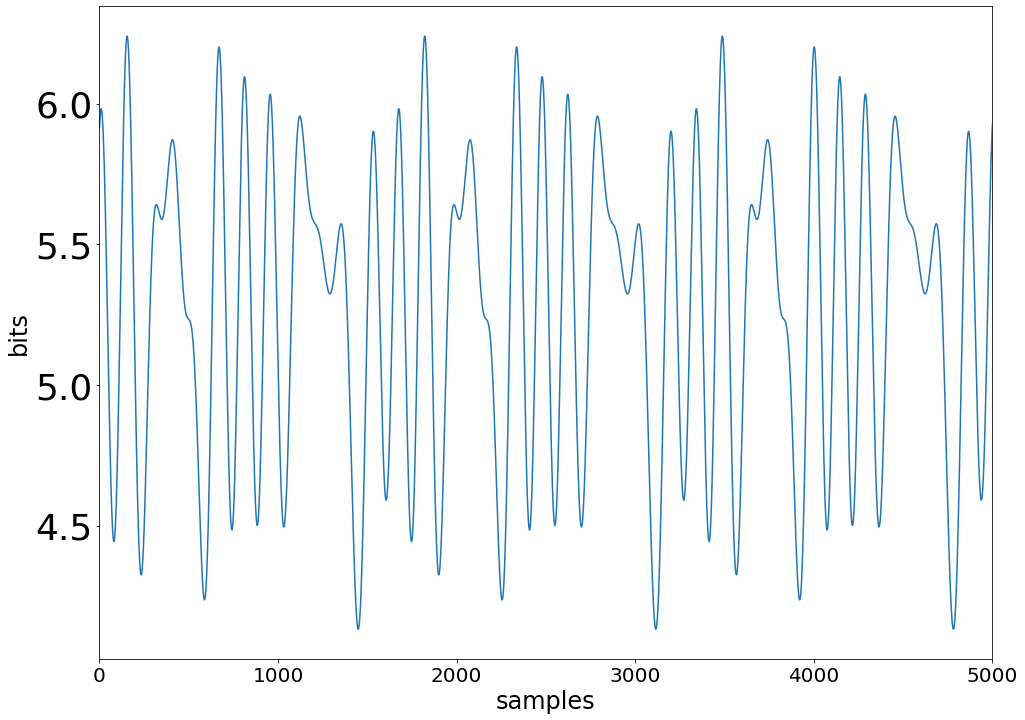

In [94]:
plt.plot(z_trans_amp)
#plt.plot(np.divide(signal_sim_shift,2e-17)*scale)
plt.xlim(0,5000)
plt.ylabel("bits")
plt.xlabel("samples")

In [95]:
### add noise or noise +bkg
with h5py.File('bck_noise.h5', 'r') as f_in:
    quad_data_raw = np.array(f_in['quad_data'])
    raw_data = quad_data_raw.reshape(-1,12).T[9]
    f_in.close()
    

In [138]:
a = np.random.uniform(-0.5,0.5,len(data_in))

In [139]:
c = a + data_in

(0.0, 100.0)

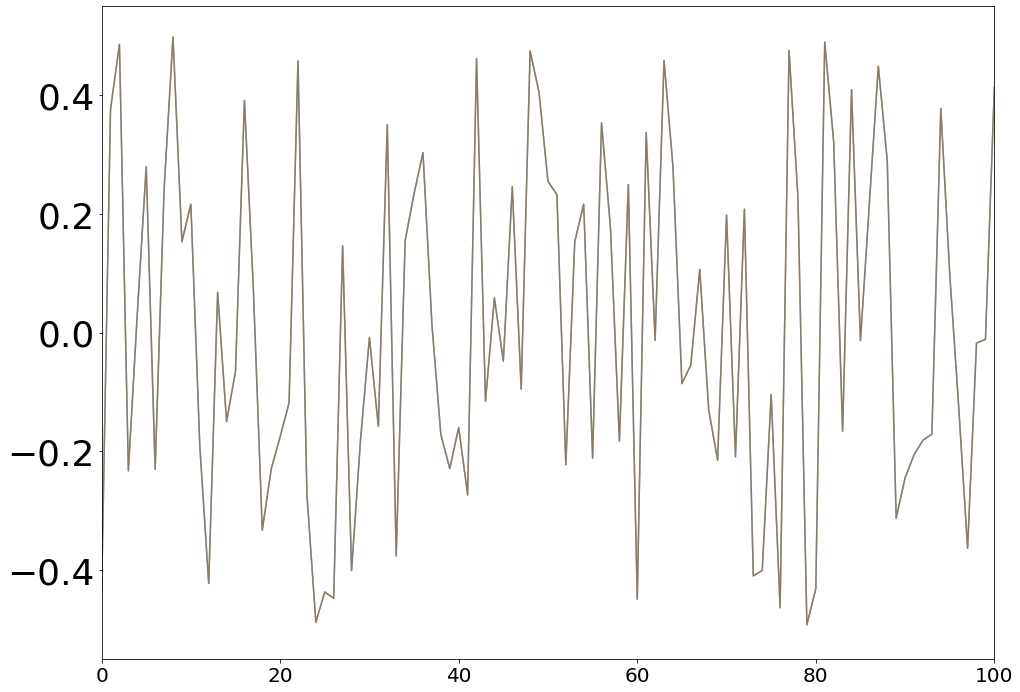

In [147]:
plt.plot(c-data_in)
plt.plot(a,alpha=0.5)
plt.xlim(0,100)

In [256]:
file_path = "bck_noise.h5"
with h5py.File(file_path, 'r') as f_in:
    quad_data_in = np.array(f_in['quad_data'])
    data_in = quad_data_in.reshape(-1,12).T[9]
    new_data_norm = []
    new_data_uni = []
    start = time.time()
    #for element in data_in:
        #new_data_norm.append(np.random.normal(element,0.5))  
    a = np.random.uniform(-0.5,0.5,len(data_in))
    print(np.mean(data_in))
    new_data_uni = data_in + a
    #[new_data_uni.append(element+np.random.uniform(-0.5,0.5)) for element in data_in]
    #z_sn = np.add(np.array(data_in),np.array(z_trans_amp))
    #z_sn_norm = np.add(np.array(new_data_norm),np.array(z_trans_amp))
    z_sn_uni =  np.add(np.array(new_data_uni),np.array(z_trans_amp))
    end = time.time()
    print((end-start))
    z_sn_round_fix = [round(element) for element in z_sn_uni]
    #z_sn = np.subtract(np.array(data_in),np.array(z_trans_amp))
    quad_data_in.reshape(-1,12).T[9] = z_sn_round_fix
    f_in.close()
    #plt.plot(np.array(z_sn),color="black")
out_path = "test_digi.h5"
copyfile(src=file_path, dst=out_path)
with h5py.File(out_path, 'r+') as f_out:
    del f_out['quad_data']
    f_out.create_dataset("quad_data", quad_data_in.shape,data=quad_data_in)
    f_out.close()

-3242722.34424
0.00174713134765625


In [269]:
print(np.std(data_in)/2500)


1.35026438451


In [117]:
digi_0 = quad_data_in.reshape(-1,12).T[9]
#digi_norm = quad_data_in.reshape(-1,12).T[9]
#digi_uni = quad_data_in.reshape(-1,12).T[9]
#digi_old = quad_data_in.reshape(-1,12).T[9]

(0.0, 5000.0)

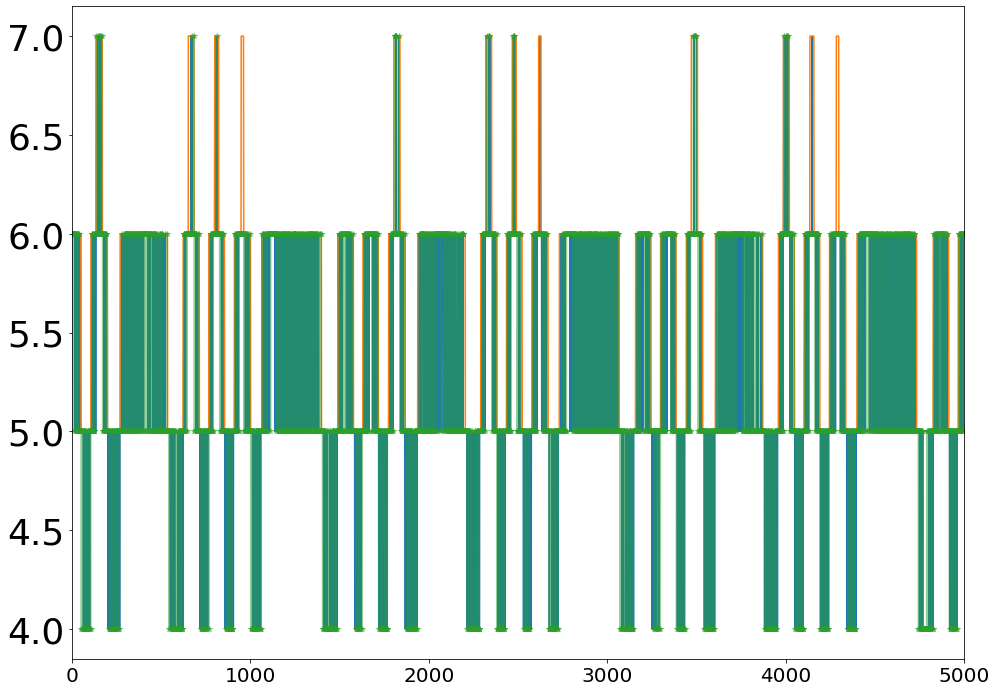

In [120]:
plt.plot(digi_0-raw_data)
plt.plot(digi_old-raw_data)
#plt.plot(digi_norm-raw_data,alpha=0.5,marker="*")
plt.plot(digi_uni-raw_data,alpha=0.5,marker="*")


plt.xlim(0,5000)

(10000.0, 300000.0)

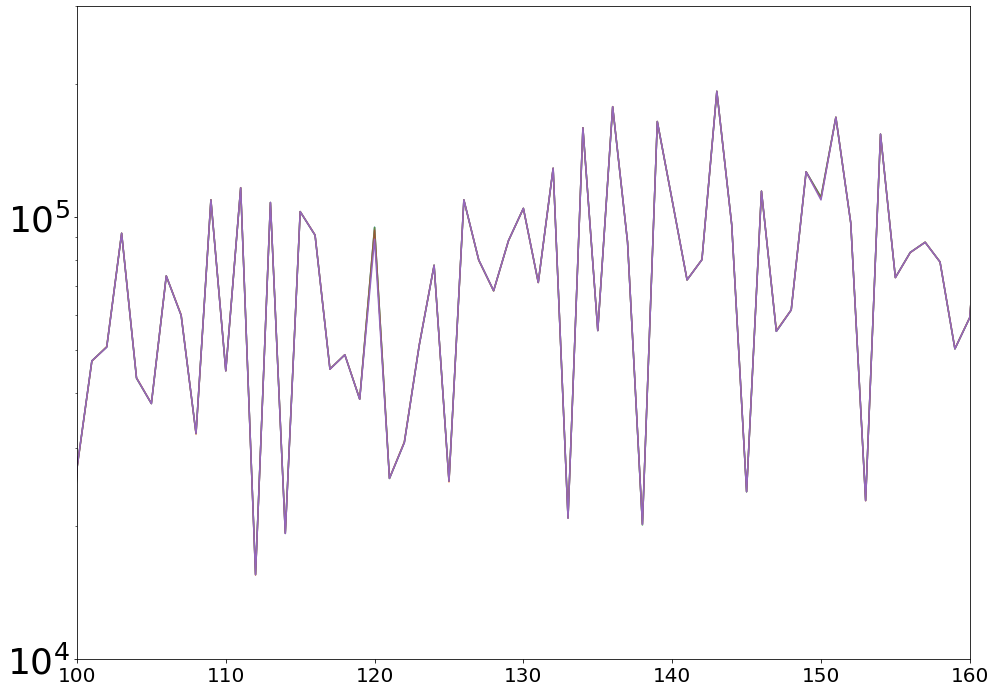

In [121]:
plt.plot(np.abs(np.fft.rfft(z_sn)))
#plt.plot(np.abs(np.fft.rfft(digi_0)),alpha=0.5)
plt.plot(np.abs(np.fft.rfft(digi_norm)),alpha=0.5)
plt.plot(np.abs(np.fft.rfft(digi_uni)),alpha=0.5)
plt.plot(np.abs(np.fft.rfft(digi_old)),alpha=0.5)


plt.plot(np.abs(np.fft.rfft(raw_data)))

plt.yscale("log")
plt.axvline(390)
plt.xlim(100,160)
plt.ylim(1e4,3e5)

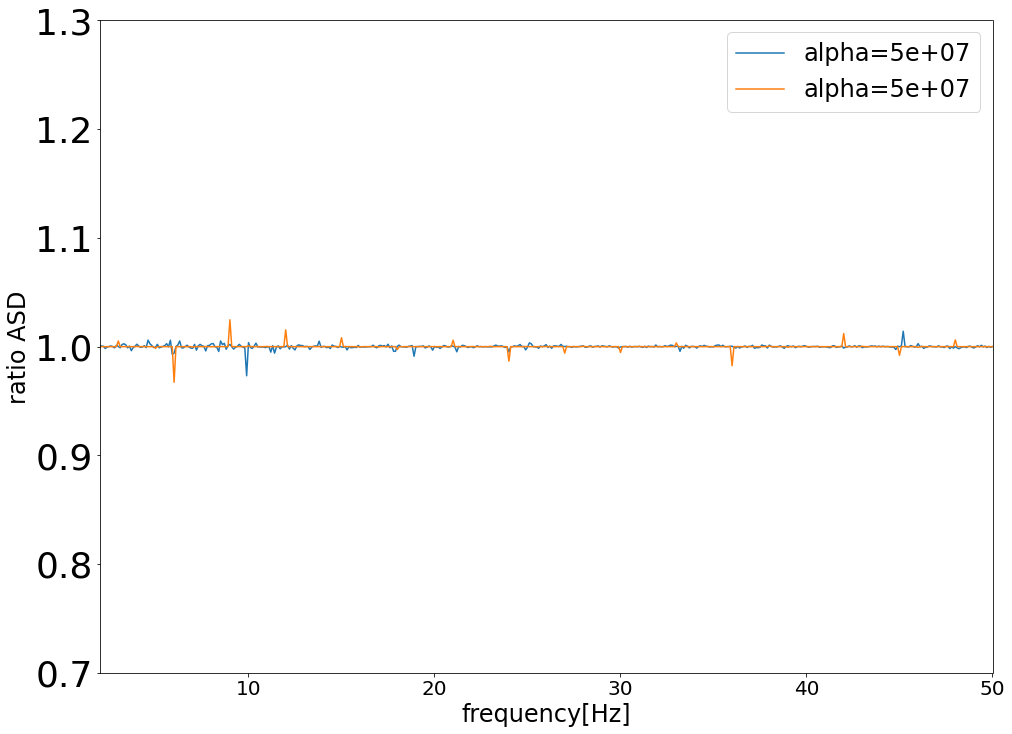

In [124]:
x=np.arange(0,2500.1,0.1)
#plt.plot(x,np.abs(np.fft.rfft(z_sn))/(np.abs(np.fft.rfft(digi_0))),label="alpha=%2.0e" %scale)
#plt.plot(x,np.abs(np.fft.rfft(z_sn))/(np.abs(np.fft.rfft(digi_norm))),label="alpha=%2.0e" %scale)
plt.plot(x,np.abs(np.fft.rfft(z_sn))/(np.abs(np.fft.rfft(digi_uni))),label="alpha=%2.0e" %scale)
plt.plot(x,np.abs(np.fft.rfft(z_sn))/(np.abs(np.fft.rfft(digi_old))),label="alpha=%2.0e" %scale)
#plt.plot(x,np.abs(np.fft.rfft(z_sn))/(np.abs(np.fft.rfft(raw_data))),label="alpha=%2.0e" %scale)


plt.xlim(2,50)
plt.ylim(0.7,1.3)
#plt.axvline(240)
plt.ylabel("ratio ASD")
plt.xlabel("frequency[Hz]")
plt.legend()

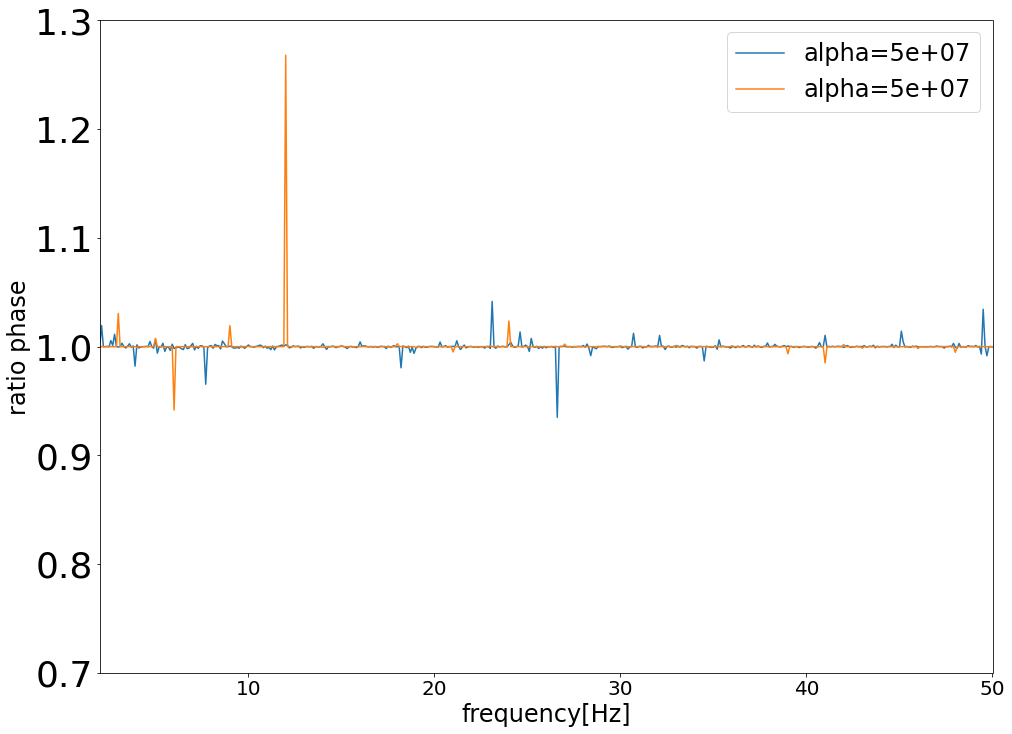

In [125]:
x=np.arange(0,2500.1,0.1)
#plt.plot(x,np.angle(np.fft.rfft(z_sn))/(np.angle(np.fft.rfft(digi_0))),label="alpha=%2.0e" %scale)
#plt.plot(x,np.angle(np.fft.rfft(z_sn))/(np.angle(np.fft.rfft(digi_norm))),label="alpha=%2.0e" %scale)
plt.plot(x,np.angle(np.fft.rfft(z_sn))/(np.angle(np.fft.rfft(digi_uni))),label="alpha=%2.0e" %scale)
plt.plot(x,np.angle(np.fft.rfft(z_sn))/(np.angle(np.fft.rfft(digi_old))),label="alpha=%2.0e" %scale)
#plt.plot(x,np.angle(np.fft.rfft(z_sn))/(np.angle(np.fft.rfft(raw_data))),label="alpha=%2.0e" %scale, alpha=0.5)


plt.xlim(2,50)
plt.ylim(0.7,1.3)
#plt.axvline(240)
plt.ylabel("ratio phase")
plt.xlabel("frequency[Hz]")
plt.legend()

In [2]:
file_path = "/data/new_trap/20201211/Bead1/Discharge/Neutrality_20201211/Discharge_4.h5"
with h5py.File(file_path, 'r') as f_in:
    quad_data_in = np.array(f_in['quad_data'])
    data_in_bead = quad_data_in.reshape(-1,12).T[9]

In [3]:
file_path = "/data/new_trap/20201211/Bead1/InitialTest/Data14.h5"
with h5py.File(file_path, 'r') as f_in:
    quad_data_in = np.array(f_in['quad_data'])
    data_in_attr = quad_data_in.reshape(-1,12).T[9]

In [4]:
file_path = "/data/new_trap/20201211/Bead1/InitialTest/Data19.h5"
with h5py.File(file_path, 'r') as f_in:
    quad_data_in = np.array(f_in['quad_data'])
    data_in_srs = quad_data_in.reshape(-1,12).T[9]

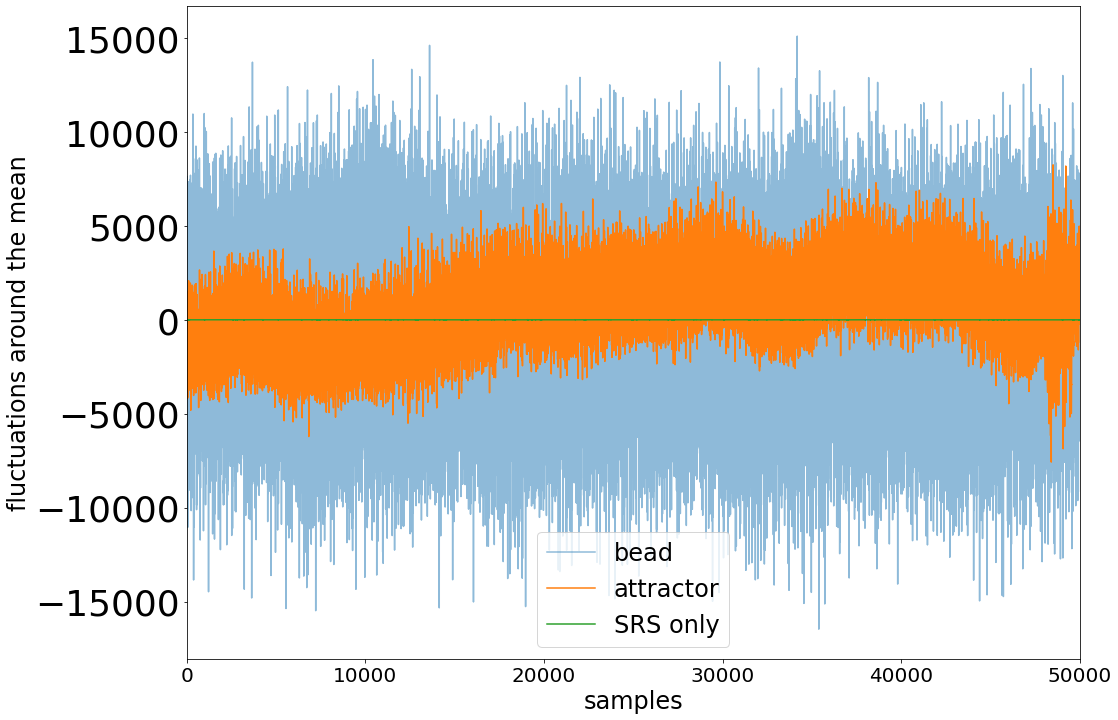

In [5]:
#plt.plot(data_in_attr-np.mean(data_in_attr))
plt.plot(data_in_bead-np.mean(data_in_bead),alpha=0.5, label="bead")
plt.plot(data_in_attr-np.mean(data_in_attr),label="attractor")
plt.plot(data_in_srs-np.mean(data_in_srs),label="SRS only")
plt.ylabel("fluctuations around the mean")
plt.xlabel("samples")
plt.xlim(0,50000)
plt.legend()

(10.0, 100000000.0)

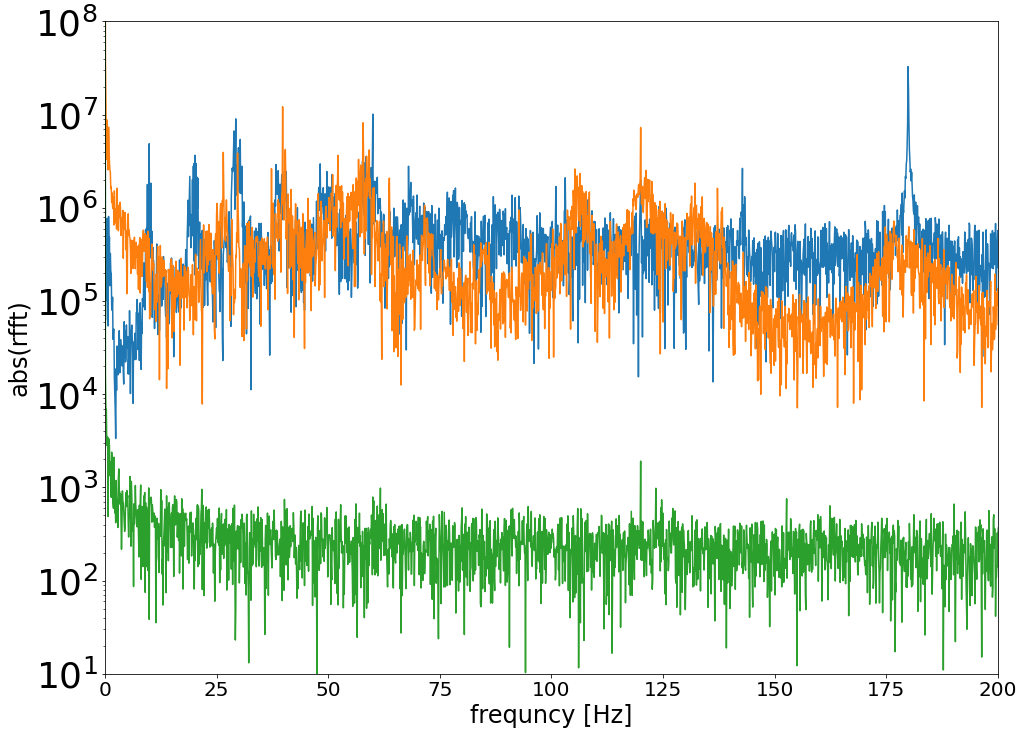

In [6]:
x=np.arange(0,2500.1,0.1)
plt.plot(x,np.abs(np.fft.rfft(data_in_bead)))
plt.plot(x,np.abs(np.fft.rfft(data_in_attr)))
plt.plot(x,np.abs(np.fft.rfft(data_in_srs)))
plt.yscale("log")
plt.xlim(0,200)
plt.xlabel("frequncy [Hz]")
plt.ylabel("abs(rfft)")
plt.ylim(1e1,1e8)

(1.0, 10000.0)

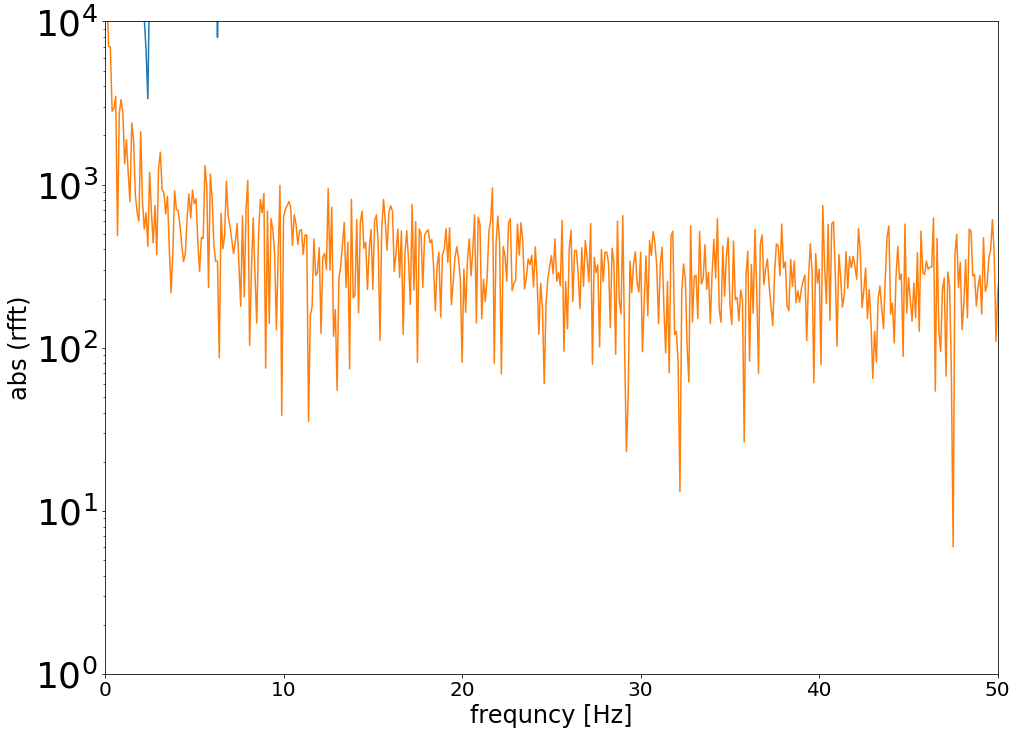

In [17]:
x=np.arange(0,2500.1,0.1)
plt.plot(x,np.abs(np.fft.rfft(data_in_bead)))
#plt.plot(x,np.sqrt(np.abs(np.fft.rfft(data_in_attr))))
plt.plot(x,np.abs(np.fft.rfft(data_in_srs)))
plt.yscale("log")
plt.xlim(0,50)
plt.xlabel("frequncy [Hz]")
plt.ylabel("abs (rfft)")
plt.ylim(1e0,1e4)

(0.0, 50000.0)

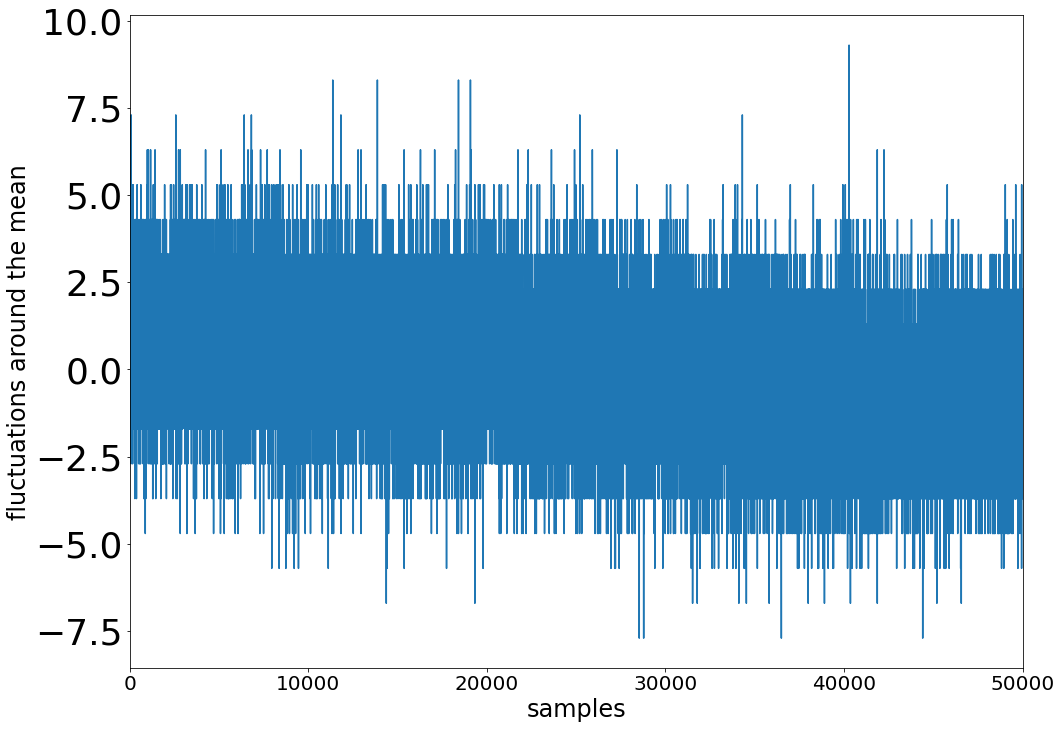

In [252]:
plt.plot(data_in_srs-np.mean(data_in_srs),label="SRS only")
plt.ylabel("fluctuations around the mean")
plt.xlabel("samples")
plt.xlim(0,50000)